In [77]:
%matplotlib inline

In [78]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from IPython.display import clear_output
from ipywidgets import interact

plt.ion()

In [97]:
# Constants

GAMMA = 0.9
IN = 1
HIDDEN = 10
STATES = 10
OUT = 3

In [98]:
# Normalize integer input

all_states = np.array([i for i in range(STATES)])
mean = all_states.mean()
std = all_states.std()

def normalize(s):
    return (s-mean)/std

In [99]:
def vis_q():
    qlist = np.array([y.eval({x: [[normalize(s)]]}) for s in range(STATES)])
    plt.plot(qlist[:,0], c='r')
    plt.plot(qlist[:,1], c='g')
    plt.plot(qlist[:,2], c='b')
    
def ds_with_action(action_id):
    if action_id == 0:
        return 0
    elif action_id == 1:
        return -1
    elif action_id == 2:
        return 1

In [100]:
# Define network to approximate q values

x = tf.placeholder(tf.float32)
t = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal((HIDDEN, IN)))
b1 = tf.Variable(tf.random_normal((HIDDEN, 1)))

W2 = tf.Variable(tf.random_normal((OUT, HIDDEN)))
b2 = tf.Variable(tf.random_normal((OUT, 1)))

h1 = tf.tanh(tf.matmul(W1, x) + b1)
y = tf.matmul(W2, h1) + b2

cost = tf.reduce_mean(tf.square(y - t))

In [101]:
if 'session' in globals():
    session.close()
    
session = tf.InteractiveSession()
session.run(tf.initialize_all_variables())

In [104]:
train = tf.train.GradientDescentOptimizer(0.001).minimize(cost)

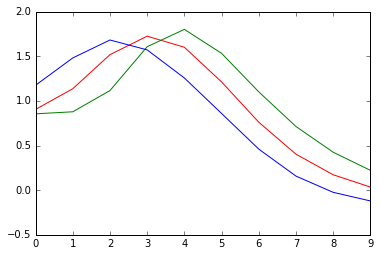

0.0100209


In [105]:
target_state = STATES/2

for i in range(10000):
    # Pick a random state
    s1 = np.random.randint(STATES)
    dist1 = abs(s1 - target_state)
    
    # Get q values for that state
    q1 = y.eval(feed_dict={x: [[normalize(s1)]]})
    
    # Choose a random action
    rand_action = np.random.randint(OUT)
    
    # Apply random action
    s2 = s1 + ds_with_action(rand_action)
    
    # Constrain s2
    if s2 < 0:
        s2 = 0
    elif s2 > STATES - 1:
        s2 = STATES - 1
        
    dist2 = abs(s2 - target_state)
    
    # Get new q values
    q2 = y.eval(feed_dict={x: [[normalize(s2)]]})
    
    # Get reward
    # reward = dist1 - dist2
    reward = 0
    if s2 == 3:
        reward = 1
        
    # Get a target for the q values
    
    # My method
    # target_q = q2 * GAMMA
    # target_q[rand_action] += reward
    
    # Tonys method
    target_q = q1
    target_q[rand_action] = reward + GAMMA * q2.mean()
    
    # Train to predict the target q next time
    session.run(train, feed_dict={x: [[normalize(s1)]], t: target_q})
    
    if i % 1000 == 0:
        c = cost.eval(feed_dict={x: [[normalize(s1)]], t: target_q})
        clear_output(wait=True)
        vis_q()
        plt.show()
        print(c)

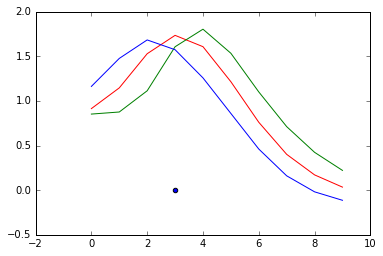

In [107]:
# Rollout of agent's behavior

for run in range(10):
    s = np.random.randint(STATES)
    for i in range(10):
        qs = y.eval({x: [[normalize(s)]]})
        best_action = np.argmax(qs)
        
        s += ds_with_action(best_action)
        
        # plot s
        clear_output(wait=True)
        #plt.axis([0, STATES-1, -6, 6])
        vis_q()
        plt.scatter([s], [0])
        plt.show()